# Trains and evaluate the 2020 classifier

In [38]:
from deepcell.datasets.visual_behavior_dataset import VisualBehaviorDataset
from deepcell.classifier import Classifier
from deepcell.models.VggBackbone import VggBackbone
from deepcell.data_splitter import DataSplitter
from deepcell.transform import Transform
from deepcell.inference import inference
from deepcell.plotting import pr_curve

import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from imgaug import augmenters as iaa
import random
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import average_precision_score

random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

In [29]:
ARTIFACT_DESTINATION = Path('/tmp/artifacts')
CHECKPOINT_PATH = Path('.').absolute().parent.parent / 'saved_models' / '2020_classifier'

In [2]:
dataset = VisualBehaviorDataset(artifact_destination=ARTIFACT_DESTINATION, 
                                exclude_projects=[
                                    'ophys-experts-slc-oct-2020_ophys-experts-go-big-or-go-home', 
                                    'ophys-expert-danielsf-additions'])

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:deepcell.datasets.visual_behavior_dataset:Reading manifests and preprocessing
INFO:deepcell.datasets.visual_behavior_dataset:Dataset already downloaded...


In [3]:
len(dataset.dataset)

2087

In [5]:
dataset.project_meta.groupby('project_name')['date'].agg(['min', 'max'])

,min,max
project_name,,
ophys-experts-go-big-or-go-home,2020-11-27T22:47:25.996000,2020-12-04T00:41:02.252000
ophys-experts-slc-oct-2020,2020-10-26T18:41:36.928000,2020-10-29T03:07:02.104000


In [6]:
dataset.project_meta.groupby('project_name').size()

project_name
ophys-experts-go-big-or-go-home    1598
ophys-experts-slc-oct-2020          489
dtype: int64

In [4]:
all_transform = transforms.Compose([
    iaa.Sequential([
        iaa.Sometimes(0.5, iaa.Affine(scale=(0.7, 1.3), rotate=(-360, 360), order=0)),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.CenterCropToFixedSize(height=60, width=60),
    ]).augment_image,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform = Transform(all_transform=all_transform)

In [5]:
all_transform = transforms.Compose([
    iaa.Sequential([
        iaa.CenterCropToFixedSize(height=60, width=60)
    ]).augment_image,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = Transform(all_transform=all_transform)

In [6]:
data_splitter = DataSplitter(artifacts=dataset.dataset, train_transform=train_transform,
                             test_transform=test_transform, seed=1234, image_dim=(128, 128))
train, test = data_splitter.get_train_test_split(test_size=.3)
train_dataloader = DataLoader(dataset=train, shuffle=True, batch_size=32)

In [7]:
print(len(train) + len(test))
print(train.y.mean())
print(len(test))

2087
0.26164383561643834
627


In [7]:
cnn = torchvision.models.vgg11_bn(pretrained=True, progress=False)

In [8]:
cnn

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
cnn = torchvision.models.vgg11_bn(pretrained=True, progress=False)
cnn = VggBackbone(model=cnn, truncate_to_layer=15, classifier_cfg=[512, 512], dropout_prob=.7, freeze_up_to_layer=15)
optimizer = lambda: torch.optim.Adam(cnn.classifier.parameters(), lr=0.0004, weight_decay=0.0)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]))
scheduler = lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=40, verbose=True, factor=.5)
classifier = Classifier(model=cnn, n_epochs=1000, optimizer=optimizer, scheduler=scheduler,
                        criterion=criterion, save_path=CHECKPOINT_PATH, early_stopping=60)
cv_metrics = classifier.cross_validate(train_dataset=train, data_splitter=data_splitter, batch_size=32, 
                                       save_model=False)

In [36]:
cv_metrics.metrics

{'train_loss': 0.421681628935039, 'valid_loss': 0.4377533903345466}

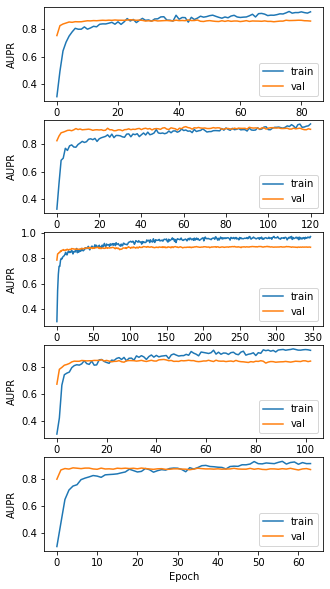

In [185]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(5, 10))

for i in range(5):
    ax[i].plot(cv_metrics.train_metrics[i].auprs[:cv_metrics.train_metrics[i].best_epoch + 60], label='train')
    ax[i].plot(cv_metrics.valid_metrics[i].auprs[:cv_metrics.train_metrics[i].best_epoch + 60], label='val')
    ax[i].legend()
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('AUPR')

plt.show()

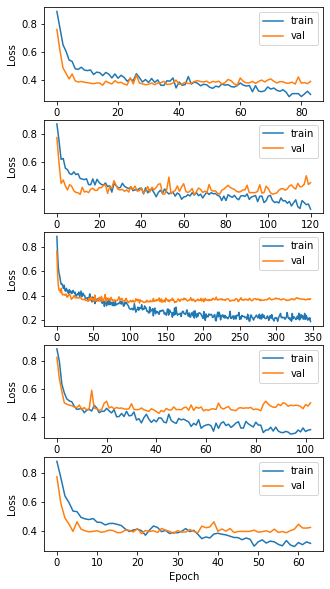

In [186]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(5, 10))

for i in range(5):
    ax[i].plot(cv_metrics.train_metrics[i].losses[:cv_metrics.train_metrics[i].best_epoch + 60], label='train')
    ax[i].plot(cv_metrics.valid_metrics[i].losses[:cv_metrics.train_metrics[i].best_epoch + 60], label='val')
    ax[i].legend()
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Loss')

plt.show()

In [30]:
cnn = torchvision.models.vgg11_bn(pretrained=True, progress=False)
cnn = VggBackbone(model=cnn, truncate_to_layer=15, classifier_cfg=[512, 512], dropout_prob=.7, freeze_up_to_layer=15)
test_loader = DataLoader(dataset=test, shuffle=False, batch_size=64)
test_metrics, res = inference(model=cnn, test_loader=test_loader, 
                              threshold=0.3, checkpoint_path=CHECKPOINT_PATH)
res['y_true'] = test.y

0_model.pt precision: 0.5346534653465347
0_model.pt recall: 0.9878048780487805
0_model.pt f1: 0.6937901498929336
1_model.pt precision: 0.6044776119402985
1_model.pt recall: 0.9878048780487805
1_model.pt f1: 0.7499999999999999
3_model.pt precision: 0.691304347826087
3_model.pt recall: 0.9695121951219512
3_model.pt f1: 0.8071065989847716
2_model.pt precision: 0.755868544600939
2_model.pt recall: 0.9817073170731707
2_model.pt f1: 0.8541114058355438
4_model.pt precision: 0.6205533596837944
4_model.pt recall: 0.9573170731707317
4_model.pt f1: 0.7529976019184652


In [31]:
print(f'precision: {test_metrics.precision}')
print(f'recall: {test_metrics.recall}')
print(f'f1: {test_metrics.F1}')

precision: 0.6356589147286822
recall: 1.0
f1: 0.7772511848341233


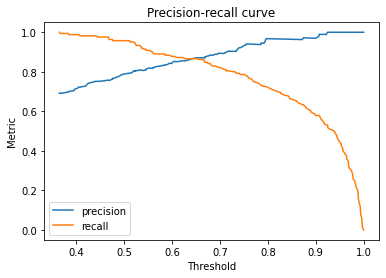

In [39]:
fig = pr_curve(res['y_score'], res['y_true'])

In [ ]:
average_precision_score(y_score=res['y_score'], y_true=res['y_true'])